# Report_3 服装分类

* 姓名：何文韬
* 学号：2021300234


## 任务简介

* 任务：对图像进行分类。给定一张28x28像素的灰度图像，目标是将其分类到10个不同的类别中，每个类别代表了一种不同的时尚商品，例如鞋子、衬衫、裤子等。

* 背景介绍：FashionMNIST 是一个替代 MNIST 手写数字集的图像数据集。 它是由 Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自 10 种类别的共 7 万个不同商品的正面图片。
FashionMNIST 的大小、格式和训练集/测试集划分与原始的 MNIST 完全一致。60000/10000 的训练测试数据划分，28x28 的灰度图片。你可以直接用它来测试你的机器学习和深度学习算法性能，且不需要改动任何的代码。
这个数据集的样子大致如下（每个类别占三行）：

* 数据格式：给出的数据的格式为.npy通过numpy库进行读取；抓取的数据是.jpg格式，需要转换为数组形式

* 最终目标：完成多分类，并且可以对抓取的数据进行分类

## 解决途径

### 1、整体的思路

这是多分类的问题，需要我们先训练模型再进行预测，其次需要我们编写爬虫程序，抓取一些衣服和鞋子的图片并且进行分类，然后放入模型之中进行预测。

### 2、选用的方法及实现的过程

首先手动读取解压的fashion-mnist文件夹中.npy文件的数据

In [1]:
import numpy as np
test_images=np.load('fashion-mnist/train-images.npy')
test_labels=np.load('fashion-mnist/train-labels.npy')
train_images=np.load('fashion-mnist/t10k-images.npy')
train_labels=np.load('fashion-mnist/t10k-labels.npy')


images每一行存放每件物品28*28的灰度值，labels按0-9，依次代表'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'

可视化一个物品看看

T-shirt/top


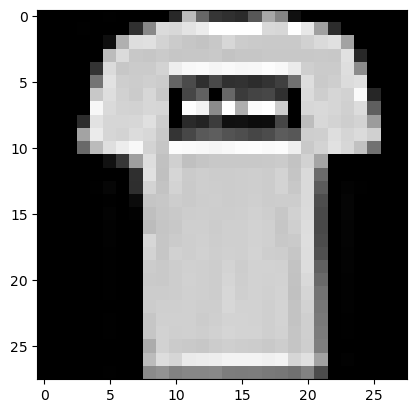

In [60]:
import matplotlib.pyplot as plt 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
y=np.reshape(train_images[1],(28,28))
plt.imshow(y.astype('uint8'), cmap='gray')
print(class_names[train_labels[1]])


#### 对数据的处理

由于原始数据的图片已经是灰度值矩阵，直接对其归一化，标准变换

我们只需要对已有数据进行归一化，标准化变换即可。

In [3]:
import torch
def data_tf(x):
    x=np.array(x,dtype='float32')/255 #归一化
    x=(x-0.5)/0.5 #标准化
    x=torch.from_numpy(x)
    return x
train_data=data_tf(train_images)
train_label=torch.from_numpy(train_labels)
test_data=data_tf(test_images)
test_label=torch.from_numpy(test_labels)


In [4]:
import torch.utils.data as Data
#将特征和label合成一个tensor，方便后续迭代器操作
train_set=Data.TensorDataset(train_data,train_label)
test_set=Data.TensorDataset(test_data,test_label)


In [5]:
from torch.utils.data import DataLoader
#使用 pytorch 自带的 DataLoader 定义一个数据迭代器
train_data=DataLoader(train_set, batch_size=64, shuffle=True)
test_data=DataLoader(test_set, batch_size=128, shuffle=False)


#### 模型的构建

构建深度神经网络

In [6]:
from torch import nn
from torch.autograd import Variable
# 使用 Sequential 定义 4层神经网络
net = nn.Sequential(
                    nn.Linear(784, 400),
                    nn.ReLU(),
                    nn.Linear(400, 200),
                    nn.ReLU(),
                    nn.Linear(200, 100),
                    nn.ReLU(),
                    nn.Linear(100, 10)
                    )


In [7]:
#定义loss函数
criterion = nn.CrossEntropyLoss()
#使用随机梯度下降，学习率 0.1
optimizer = torch.optim.SGD(net.parameters(), 1e-1)


In [8]:
#开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(20):
    train_loss = 0
    train_acc = 0
    net.train()
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label).long()
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss+=loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = float((pred == label).sum().item())
        acc = num_correct / im.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    net.eval() # 将模型改为预测模式
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        label=label.long()
        out = net(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = float((pred == label).sum().item())
        acc = num_correct / im.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))
    
#save net
torch.save(net, 'net.pkl')   # 保存整个网络
torch.save(net.state_dict(), 'net_params.pkl') # 只保存网络中的参数 (速度快, 占内存少)   


epoch: 0, Train Loss: 0.632325, Train Acc: 0.766541, Eval Loss: 0.552019, Eval Acc: 0.799248
epoch: 1, Train Loss: 0.407696, Train Acc: 0.847631, Eval Loss: 0.402980, Eval Acc: 0.855914
epoch: 2, Train Loss: 0.362449, Train Acc: 0.866005, Eval Loss: 0.480647, Eval Acc: 0.823576
epoch: 3, Train Loss: 0.329746, Train Acc: 0.877465, Eval Loss: 0.408234, Eval Acc: 0.855716
epoch: 4, Train Loss: 0.310784, Train Acc: 0.884245, Eval Loss: 0.460457, Eval Acc: 0.839102
epoch: 5, Train Loss: 0.293338, Train Acc: 0.891075, Eval Loss: 0.372059, Eval Acc: 0.864517
epoch: 6, Train Loss: 0.276216, Train Acc: 0.897821, Eval Loss: 0.371044, Eval Acc: 0.867979
epoch: 7, Train Loss: 0.262778, Train Acc: 0.901369, Eval Loss: 0.378303, Eval Acc: 0.871242
epoch: 8, Train Loss: 0.250026, Train Acc: 0.906067, Eval Loss: 0.363843, Eval Acc: 0.870154
epoch: 9, Train Loss: 0.240959, Train Acc: 0.910031, Eval Loss: 0.329335, Eval Acc: 0.888054
epoch: 10, Train Loss: 0.232229, Train Acc: 0.911864, Eval Loss: 0.332



#### 编写爬虫程序，爬取必应上的图片

这里选择爬取10种商品各一页，另外新建一个picture文件夹用来存放爬到的图片

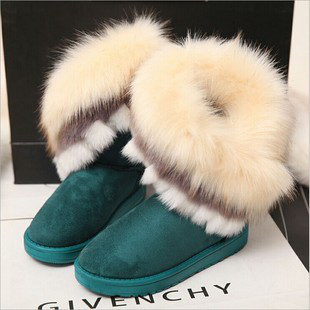

In [63]:
import re
import requests
from bs4 import BeautifulSoup

#抓取网页上一整页Ankle boot的图片
url = 'https://www.bing.com/images/search?q=Ankle+boot&form=HDRSC2&first=1'
html = requests.get(url).text  #获取网页内容
soup = BeautifulSoup(html,'html.parser')
pic_url = soup.find_all('img',src=re.compile(r'^https://img.alicdn.com/bao/uploaded/.*?jpg$'))
i = 0
for url in pic_url:
    img = url['src']
    try:
        pic = requests.get(img,timeout=500)  #超时异常判断：5秒超时
    except requests.exceptions.ConnectionError:
        print('当前图片无法下载')
        continue
    file_name = "picture/Ankle boot"+"."+str(i)+".jpg" #拼接图片名
    fp = open(file_name,'wb')
    fp.write(pic.content) #写入图片
    fp.close()
    i += 1
display(Image.open("picture/Ankle boot.0.jpg"))

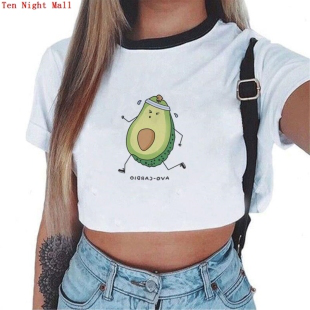

In [65]:
#抓取一页的T-shirt/top
url = 'https://www.bing.com/images/search?q=Ankle+boot&form=HDRSC2&first=1'
html = requests.get(url).text  #获取网页内容
soup = BeautifulSoup(html,'html.parser',from_encoding='utf-8')
pic_url = soup.find_all('img',src=re.compile(r'^https://img.alicdn.com/bao/uploaded/.*?jpg$'))
i = 0
for url in pic_url:
    img = url['src']
    try:
        pic = requests.get(img,timeout=500)  #超时异常判断：5秒超时
    except requests.exceptions.ConnectionError:
        print('当前图片无法下载')
        continue
    file_name = "picture/T-shirt"+"."+str(i)+".jpg" #拼接图片名
    fp = open(file_name,'wb')
    fp.write(pic.content) #写入图片
    fp.close()
    i += 1
display(Image.open("picture/T-shirt.1.jpg"))

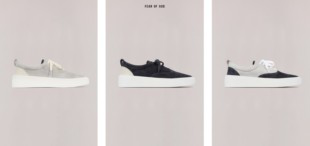

In [67]:
#抓取一页的Sneaker
url = 'https://www.bing.com/images/search?q=T-shirt&qs=n&form=QBIR&sp=-1&lq=0&pq=t-shirt&sc=10-7&cvid=940BFBA39DEB4AA6A8BB0A6465714635&ghsh=0&ghacc=0&first=1'
html = requests.get(url).text  #获取网页内容
soup = BeautifulSoup(html,'html.parser',from_encoding='utf-8')
pic_url = soup.find_all('img',src=re.compile(r'^https://img.alicdn.com/bao/uploaded/.*?jpg$'))
i = 0
for url in pic_url:
    img = url['src']
    try:
        pic = requests.get(img,timeout=500)  #超时异常判断：5秒超时
    except requests.exceptions.ConnectionError:
        print('当前图片无法下载')
        continue
    file_name = "picture/Sneaker"+"."+str(i)+".jpg" #拼接图片名
    fp = open(file_name,'wb')
    fp.write(pic.content) #写入图片
    fp.close()
    i += 1
display(Image.open("picture/Sneaker.1.jpg"))

In [46]:
#抓取一页的Pullover
url = 'https://www.bing.com/images/search?q=Sneaker&qs=n&form=QBIR&sp=-1&lq=0&pq=sneaker&sc=10-7&cvid=EA1D0061C9CB42819CB62BC4286A068C&ghsh=0&ghacc=0&first=1'
html = requests.get(url).text  #获取网页内容
soup = BeautifulSoup(html,'html.parser',from_encoding='utf-8')
pic_url = soup.find_all('img',src=re.compile(r'^https://img.alicdn.com/bao/uploaded/.*?jpg$'))
i = 0
for url in pic_url:
    img = url['src']
    try:
        pic = requests.get(img,timeout=500)  #超时异常判断：5秒超时
    except requests.exceptions.ConnectionError:
        print('当前图片无法下载')
        continue
    file_name = "picture/Pullover"+"."+str(i)+".jpg" #拼接图片名
    fp = open(file_name,'wb')
    fp.write(pic.content) #写入图片
    fp.close()
    i += 1
display(Image.open("picture/Pullover.1.jpg"))

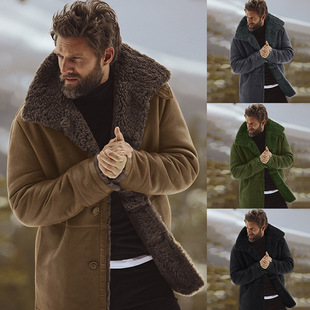

In [68]:
#抓取一页的Coat
url = 'https://www.bing.com/images/search?q=Pullover&qs=n&form=QBIR&sp=-1&lq=0&pq=pullover&sc=10-8&cvid=98B37379379B402C8B30CEFF6936B07D&ghsh=0&ghacc=0&first=1'
html = requests.get(url).text  #获取网页内容
soup = BeautifulSoup(html,'html.parser',from_encoding='utf-8')
pic_url = soup.find_all('img',src=re.compile(r'^https://img.alicdn.com/bao/uploaded/.*?jpg$'))
i = 0
for url in pic_url:
    img = url['src']
    try:
        pic = requests.get(img,timeout=500)  #超时异常判断：5秒超时
    except requests.exceptions.ConnectionError:
        print('当前图片无法下载')
        continue
    file_name = "picture/Coat"+"."+str(i)+".jpg" #拼接图片名
    fp = open(file_name,'wb')
    fp.write(pic.content) #写入图片
    fp.close()
    i += 1
display(Image.open("picture/Coat.1.jpg"))

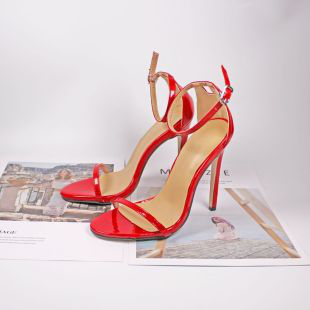

In [79]:
#抓取一页的Sandal
url = 'https://www.bing.com/images/search?q=Sandal&qs=n&form=QBIR&sp=-1&lq=0&pq=sandal&sc=10-6&cvid=4E858476D2144032A27F91F44BD61308&ghsh=0&ghacc=0&first=1'
html = requests.get(url).text  #获取网页内容
soup = BeautifulSoup(html,'html.parser',from_encoding='utf-8')
pic_url = soup.find_all('img',src=re.compile(r'^https://img.alicdn.com/bao/uploaded/.*?jpg$'))
i = 0
for url in pic_url:
    img = url['src']
    try:
        pic = requests.get(img,timeout=500)  #超时异常判断：5秒超时
    except requests.exceptions.ConnectionError:
        print('当前图片无法下载')
        continue
    file_name = "picture/Sandal"+"."+str(i)+".jpg" #拼接图片名
    fp = open(file_name,'wb')
    fp.write(pic.content) #写入图片
    fp.close()
    i += 1
display(Image.open("picture/Sandal.1.jpg"))

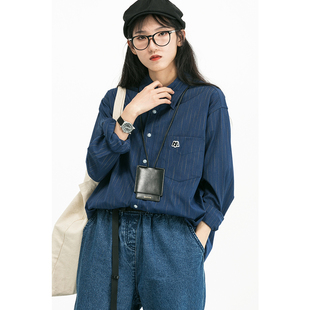

In [80]:
#抓取一页的Shirt
url = 'https://www.bing.com/images/search?q=Sandal&qs=n&form=QBIR&sp=-1&lq=0&pq=sandal&sc=10-6&cvid=4E858476D2144032A27F91F44BD61308&ghsh=0&ghacc=0&first=1'
html = requests.get(url).text  #获取网页内容
soup = BeautifulSoup(html,'html.parser',from_encoding='utf-8')
pic_url = soup.find_all('img',src=re.compile(r'^https://img.alicdn.com/bao/uploaded/.*?jpg$'))
i = 0
for url in pic_url:
    img = url['src']
    try:
        pic = requests.get(img,timeout=500)  #超时异常判断：5秒超时
    except requests.exceptions.ConnectionError:
        print('当前图片无法下载')
        continue
    file_name = "picture/Shirt"+"."+str(i)+".jpg" #拼接图片名
    fp = open(file_name,'wb')
    fp.write(pic.content) #写入图片
    fp.close()
    i += 1
display(Image.open("picture/Shirt.1.jpg"))

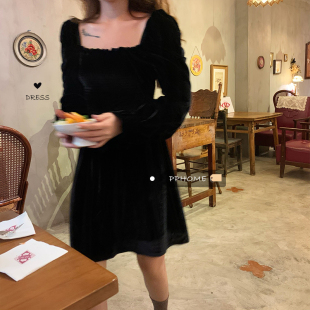

In [81]:
#抓取一页的Dress
url = 'https://www.bing.com/images/search?q=Dress&FORM=HDRSC2'
html = requests.get(url).text  #获取网页内容
soup = BeautifulSoup(html,'html.parser',from_encoding='utf-8')
pic_url = soup.find_all('img',src=re.compile(r'^https://img.alicdn.com/bao/uploaded/.*?jpg$'))
i = 0
for url in pic_url:
    img = url['src']
    try:
        pic = requests.get(img,timeout=500)  #超时异常判断：5秒超时
    except requests.exceptions.ConnectionError:
        print('当前图片无法下载')
        continue
    file_name = "picture/Dress"+"."+str(i)+".jpg" #拼接图片名
    fp = open(file_name,'wb')
    fp.write(pic.content) #写入图片
    fp.close()
    i += 1
display(Image.open("picture/Dress.1.jpg"))

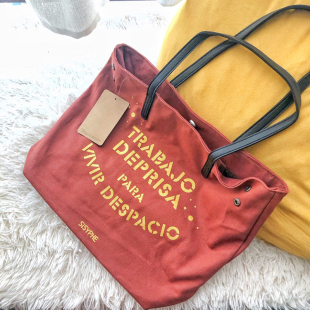

In [82]:
#抓取一页的Bag
url = 'https://www.bing.com/images/search?q=Dress&form=HDRSC2&first=1'
html = requests.get(url).text  #获取网页内容
soup = BeautifulSoup(html,'html.parser',from_encoding='utf-8')
pic_url = soup.find_all('img',src=re.compile(r'^https://img.alicdn.com/bao/uploaded/.*?jpg$'))
i = 0
for url in pic_url:
    img = url['src']
    try:
        pic = requests.get(img,timeout=500)  #超时异常判断：5秒超时
    except requests.exceptions.ConnectionError:
        print('当前图片无法下载')
        continue
    file_name = "picture/Bag"+"."+str(i)+".jpg" #拼接图片名
    fp = open(file_name,'wb')
    fp.write(pic.content) #写入图片
    fp.close()
    i += 1
display(Image.open("picture/Bag.1.jpg"))

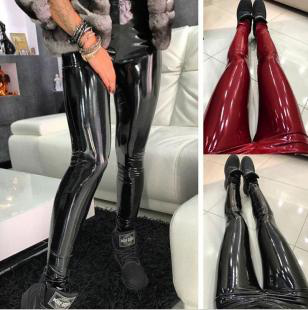

In [83]:
#最后爬取一页的Trouser
url = 'https://www.bing.com/images/search?q=Bag&qs=n&form=QBIR&sp=-1&lq=0&pq=bag&sc=10-3&cvid=01E7726EBB1C4CC5BF79E7B3BB585826&ghsh=0&ghacc=0&first=1'
html = requests.get(url).text  #获取网页内容
soup = BeautifulSoup(html,'html.parser',from_encoding='utf-8')
pic_url = soup.find_all('img',src=re.compile(r'^https://img.alicdn.com/bao/uploaded/.*?jpg$'))
i = 0
for url in pic_url:
    img = url['src']
    try:
        pic = requests.get(img,timeout=500)  #超时异常判断：5秒超时
    except requests.exceptions.ConnectionError:
        print('当前图片无法下载')
        continue
    file_name = "picture/Trouser"+"."+str(i)+".jpg" #拼接图片名
    fp = open(file_name,'wb')
    fp.write(pic.content) #写入图片
    fp.close()
    i += 1
display(Image.open("picture/Trouser.1.jpg"))

#### 利用训练好的模型进行分类

首先需要对爬取到的图片进行处理，先转换为28*28像素的灰度图。

In [74]:
from PIL import Image
import os

imgs=os.listdir("picture")
img_Num=len(imgs)
for i in range (img_Num):
    im=Image.open("picture"+"\\"+imgs[i])
    im=im.convert('L')
    im=im.resize((28,28))
    im.save("picture2"+"\\"+imgs[i])

再将灰度图转化为矩阵的形式,按爬取时的商品类型分别打上标签。

In [75]:
imgs=os.listdir("picture2")
img_Num=len(imgs)
data = np.empty((img_Num,784),dtype="float32")
label = np.empty((img_Num,),dtype="uint8")
l=[]
for i in range (img_Num):
    im=Image.open("picture2"+"\\"+imgs[i])
    im=np.array(im,dtype='float32')
    data[i,:]=im.reshape((-1,))
    l=imgs[i].split('.')
    if ('T-shirt/top' in l):
        label[i]=0
    if ('Trouser'in l):
        label[i]=1
    if ('Pullover'in l):
        label[i]=2
    if ('Dress'in l):
        label[i]=3
    if ('Coat'in l):
        label[i]=4
    if ('Sandal'in l):
        label[i]=5
    if ('Shirt'in l):
        label[i]=6
    if ('Sneaker'in l):
        label[i]=7
    if ('Bag'in l):
        label[i]=8
    if ('Ankle boot'in l):
        label[i]=9
        

In [76]:
data=data_tf(data)


调用之前训练得到的神经网络对这些数据进行预测

In [85]:
pred_net=torch.load('net.pkl')
pred=pred_net(data)
pred_label=pred.argmax(1)#预测得到label
print(pred_label)       


tensor([8, 1, 2, 3, 5, 5, 5, 6, 1, 1, 8, 4, 2, 6, 2, 2, 8, 0, 6, 8, 0, 1, 2, 8,
        5, 0, 1, 5, 3, 2, 0, 1, 5, 3, 1, 7, 8, 0, 0, 2, 2, 0, 0, 0, 0, 5, 0, 1,
        0, 5, 1, 0, 5, 5, 1, 0, 5, 5, 5, 5, 2, 1, 0, 5, 5, 9, 5, 5, 9, 9, 5, 5,
        5, 5, 0, 0, 5, 2, 5, 6, 4, 0, 1, 1, 7, 0, 8, 3, 5, 2, 0, 5, 0, 2, 0, 7,
        7, 5, 3, 7, 1, 5, 3, 5, 9, 3, 4, 5, 5, 5, 1, 3, 2, 5, 5, 5, 6, 3, 5, 8,
        5, 1, 1, 5, 5, 5, 7, 5, 6, 5, 0, 5, 5, 6, 5, 0, 5, 5, 1, 5, 5, 5, 5, 5,
        5, 0, 1, 5, 8, 0, 2, 2, 6, 8, 6, 2, 1, 2, 5, 9, 5, 0, 1, 6, 5, 0, 3, 8,
        9, 2, 2, 8, 0, 9, 7, 3, 5, 8, 0, 6, 9, 5, 3, 0, 2, 1, 3, 0, 7, 0, 0, 5,
        5, 8, 5, 5, 5, 3, 5, 1, 8, 5, 2, 9, 0, 9, 3, 3, 5, 2, 2, 8, 0, 8, 2, 0,
        0, 2, 6, 3, 2, 7, 0, 6, 1, 0, 0, 7, 8, 7, 3, 2, 6, 0, 1, 2, 6, 1, 7, 7,
        5, 4, 2, 5, 6, 5, 9, 3, 5, 5, 5, 5, 9, 1, 5, 5, 5, 5, 5, 8, 1, 8, 5, 9,
        5, 0, 4, 5, 7, 1, 0, 5, 5, 3, 4, 4, 9, 9, 6, 2, 8, 5, 1, 2, 9, 3, 3, 3,
        2, 3, 5, 5, 5, 6, 2, 9, 5])


In [78]:
#将预测得到的与实际的进行对比，得出准确率
acc=0
for i in range(len(data)):
    if label[i]==pred_label[i]:
        acc+=1
print(acc/len(data))


0.06060606060606061


可以看到对所有爬下来的图片预测的正确率非常的低

主要原因是图片中的干扰因素太多，压缩成28*28的灰度图会严重影响准确率;另外在训练神经网络时，也没有进行数据的增强，导致面对同一个物品，可能转一转就分辨错了；神经网络的很多参数，例如隐藏层层数、节点数以及学习率的选择没有深入考究，导致神经网络做出来的效果不太理想。

## 心得体会

一开始是想要爬取淘宝网上的图片，但是淘宝网上图片总是难以爬取，因此退而求其次，爬取了必应上的图片。此外，本次的深度神经网络构建也实现的不太理想，因为最后要解决的是现实世界物品的分类，需要进一步对图片提取特征的处理方法进行改进，也需要认为筛选出只有单件服饰的图片。此外，通过查询资料发现图片识别还可以采用轮廓法。

关于对于不支持类别的判断，找了很多资料，这个问题将从从闭集分类问题变成了开集分类问题，由于手头上没有不⽀持类别的数据，且难以制作，真安逸实现。此外，也可以通过最后一层输出的每一个类的概率进行判断，但介于图片识别率过低，这个简单判断方法也会有极大的误差。

这是我做的第一个报告，由于时间限制，先完成后续报告，有时间再回来完善。